In [1]:
import numpy as np
from time import time, localtime, strftime
import matplotlib.pyplot as plt
import tracemalloc
from multiprocessing import Pool, Lock

### Helpful functions and constants

In [2]:
EPS = 1e-6
CORE_COUNT = 6

# test by 1 until 50
dims = np.arange(1, 51, 1)
# test by 10 until 100
dims = np.append(dims, np.arange(60, 101, 10))
# test by 20 until 200
dims = np.append(dims, np.arange(120, 201, 20))
# test 300, 400 and 500
dims = np.append(dims, [300, 400, 500])
PERFORMANCE_TEST_DIMS = dims[::-1]

# split matrix into 4 as closely to equal (in size) parts as possible
# A = [ A11 A12 ]
#     [ A21 A22 ]
def split_matrix(A):
    r, c = A.shape
    half_r = r//2
    half_c = c//2
    A11 = A[:half_r, :half_c]
    A12 = A[:half_r, half_c:]
    A21 = A[half_r:, :half_c]
    A22 = A[half_r:, half_c:]
    return A11, A12, A21, A22

# returns count of all elments in matrix
def el_count(A):
    return A.shape[0] * A.shape[1]

# generate matrix N x N with values in given range
def generate_matrix(n, range_start=0.00000001, range_end=1.0):
    A = np.random.rand(n,n)
    diff = range_end-range_start
    return A*diff + range_start

# generate vector of length N with values in given range
def generate_vector(n, range_start=0.00000001, range_end=1.0):
    vec = np.random.rand(n, 1)
    diff = range_end-range_start
    return vec*diff + range_start

# test correctness of a function
def test_correctness(test_function, dims=[d for d in range(1, 51)], tests_per_dim=1):
    test_no = 0
    pass_count = 0
    total_tests = len(dims)*tests_per_dim
    for dim in dims:
        for t in range(tests_per_dim):
            test_no += 1
            if test_function(dim):
                pass_count += 1
            else:
                print(f"Didn't pass a test no. {test_no} for dim: {dim}")
    print(f"Passed {pass_count}/{total_tests}")
    return pass_count == total_tests

# result class
class Result:
    def __init__(self, time_elapsed, flop_count, mem_used):
        # time elapsed in ms
        self.time_elapsed = time_elapsed
        # flop count
        self.flop_count = flop_count
        # memory used in KiB
        self.mem_used = mem_used
        # flops / time in seconds
        self.flops_per_sec = flop_count / (time_elapsed / 1000)

# combine result dicts
def combine_result_dicts(result_dict_binet, result_dict_strassen):
    new_dict = {}
    for d, r in result_dict_binet.items():
        new_dict[d] = {}
        new_dict[d]["binet"] = r
    for d, r in result_dict_strassen.items():
        new_dict[d]["strassen"] = r
    return new_dict

# plot results
def plot_results(function_string, result_dict_binet, result_dict_strassen):
    # split dims and results from dicts
    dims, res_binet, res_strassen = list(), list(), list()
    for d, r in sorted(combine_result_dicts(result_dict_binet, result_dict_strassen).items()):
        dims.append(d)
        res_binet.append(r["binet"])
        res_strassen.append(r["strassen"])
    # get subplots
    fig, axes = plt.subplots(4,1)
    fig.set_size_inches(12, 32)
    axs = np.reshape(axes, -1)
    # plot results
    split_binet = [
        [res.time_elapsed for res in res_binet],
        [res.flop_count for res in res_binet],
        [res.mem_used for res in res_binet],
        [res.flops_per_sec for res in res_binet]
    ]
    split_strassen = [
        [res.time_elapsed for res in res_strassen],
        [res.flop_count for res in res_strassen],
        [res.mem_used for res in res_strassen],
        [res.flops_per_sec for res in res_strassen]
    ]
    labels = ["time elapsed [ms]", "flop count", "memory usage (KiB)", "flops per second"]
    yscales = ["linear", "linear", "linear", "linear"]
    for ax, res_bin, res_str, lbl, scl in zip(axs, split_binet, split_strassen, labels, yscales):
        ax.plot(dims, res_bin, label="binet")
        ax.plot(dims, res_str, label="strassen")
        ax.set_title(f"{lbl} by dimension for {function_string}")
        ax.set_xlabel("dimension")
        ax.set_ylabel(lbl)
        ax.set_yscale(scl)
        ax.grid()
        ax.legend()
    # show plot
    plt.show()

# read results from file
def read_results_from_file(file_path):
    try:
        results = {}
        file = open(file_path, "r")
        for line in file:
            arr = line.strip().split(",")
            results[int(arr[0])] = Result(float(arr[1]), int(arr[2]), float(arr[3]))
        file.close()
        return results
    except:
        return {}

# global lock, so it's the same between processes
lock = None

# lock initialization for Pool
def init_lock(l):
    global lock
    lock = l

# append result to file
def append_result_to_file(file_path, dim, result):
    lock.acquire()
    try:
        file = open(file_path, "a")
        file.write(f"{dim},{result.time_elapsed},{result.flop_count},{result.mem_used}\n")
        file.close()
    finally:
        lock.release()

# test functions performace
def test_performance(result_file, dims, test_function):
    results = read_results_from_file(result_file)
    new_dims = [d for d in dims if d not in results.keys()]
    l = Lock()
    
    print(f"Start: {strftime("%H:%M:%S", localtime())}")
    t0 = time()
    
    with Pool(CORE_COUNT, initializer=init_lock, initargs=(l,)) as p:
        p.map(test_function, new_dims)
    
    t1 = time()
    print(f"End: {strftime("%H:%M:%S", localtime())}")
    print(f"Finished testing in {t1-t0}s\n")
    
    return read_results_from_file(result_file)

### Binet multiplication

In [3]:
# recursive binet
def binet(A, B):
    flop_count = 0
    
    def f(A, B):
        nonlocal flop_count
        # initialize result matrix as zeros
        C = np.zeros((A.shape[0], B.shape[1]))
        # if matrices can be split further, split them
        if A.shape[0] > 1 and A.shape[1] > 1 and B.shape[1] > 1:
            # split matrices
            A11, A12, A21, A22 = split_matrix(A)
            B11, B12, B21, B22 = split_matrix(B)
            # calculate each part of the result recursively
            C11 = f(A11, B11) + f(A12, B21)
            C12 = f(A11, B12) + f(A12, B22)
            C21 = f(A21, B11) + f(A22, B21)
            C22 = f(A21, B12) + f(A22, B22)
            flop_count += el_count(C11) + el_count(C12) + el_count(C21) + el_count(C22)
            # write the result into new matrix
            half_r, half_c = C11.shape
            C[:half_r, :half_c] = C11
            C[:half_r, half_c:] = C12
            C[half_r:, :half_c] = C21
            C[half_r:, half_c:] = C22
        # if you can no longer split matrices, do normal matrix multiplication
        else:
            for r in range(C.shape[0]):
                for c in range(C.shape[1]):
                    for i in range(A.shape[1]):
                        C[r,c] += A[r,i]*B[i,c]
                        flop_count += 2
        # return resulting matrix
        return C
    
    return f(A, B), flop_count

### Strassen multiplication

In [4]:
# recursive strassen
def strassen(A, B):
    flop_count = 0
    # pad matrices
    n = A.shape[0]
    m = A.shape[1]
    k = B.shape[1]
    size_2 = 1
    while size_2 < max(n,m,k):
        size_2 *= 2
    A_padded = np.zeros((size_2, size_2))
    B_padded = np.zeros((size_2, size_2))
    A_padded[:n, :m] = A
    B_padded[:m, :k] = B
    
    def f(A, B):
        nonlocal flop_count
        n = A.shape[0]
        # initialize result matrix as zeros
        C = np.zeros((n,n))
        # if matrices can be split further, split them
        if n > 1:
            # split matrices
            A11, A12, A21, A22 = split_matrix(A)
            B11, B12, B21, B22 = split_matrix(B)
            # calculate needed values recursively
            M1 = f(A11+A22, B11+B22)
            M2 = f(A21+A22, B11)
            M3 = f(A11, B12-B22)
            M4 = f(A22, B21-B11)
            M5 = f(A11+A12, B22)
            M6 = f(A21-A11, B11+B12)
            M7 = f(A12-A22, B21+B22)
            flop_count += (n//2)**2 * 10
            # add values to create each part of result matrix
            C11 = M1 + M4 - M5 + M7
            C12 = M3 + M5
            C21 = M2 + M4
            C22 = M1 - M2 + M3 + M6
            flop_count += (n//2)**2 * 8
            # write the result into new matrix
            half_r, half_c = C11.shape
            C[:half_r, :half_c] = C11
            C[:half_r, half_c:] = C12
            C[half_r:, :half_c] = C21
            C[half_r:, half_c:] = C22
        # if you can no longer split matrices, it's 1x1 by 1x1
        else:
            C[0,0] = A[0,0]*B[0,0]
            flop_count += 1
        # return resulting matrix
        return C

    return f(A_padded, B_padded)[:n, :k], flop_count

### Matrix inversion

In [5]:
# invert matrix A
def inverse(A, mul_fun):
    flop_count = 0
    
    def f(A):
        nonlocal flop_count
        # initialize result matrix as zeros
        B = np.zeros(A.shape)
        # if matrix can be split further, split it
        if A.shape[0] > 1:
            # split matrix
            A11, A12, A21, A22 = split_matrix(A)
            # calculate inv(A11)
            A11_inv = f(A11)
            # calculate S (aka S22)
            M1, f1 = mul_fun(A21, A11_inv)
            M2, f2 = mul_fun(M1, A12)
            S = A22 - M2
            flop_count += f1 + f2 + el_count(S)
            # calculate inv(S)
            S_inv = f(S)
            # calculate B11
            M1, f1 = mul_fun(A12, S_inv)
            M2, f2 = mul_fun(M1, A21)
            M3, f3 = mul_fun(M2, A11_inv)
            B11, f4 = mul_fun(A11_inv, np.eye(M3.shape[0]) + M3)
            flop_count += f1 + f2 + f3 + f4 + M3.shape[0]
            # calculate B12
            M1, f1 = mul_fun(A11_inv, A12)
            M2, f2 = mul_fun(M1, S_inv)
            B12 = -M2
            flop_count += f1 + f2
            # calculate B21
            M1, f1 = mul_fun(S_inv, A21)
            M2, f2 = mul_fun(M1, A11_inv)
            B21 = -M2
            flop_count += f1 + f2
            # "calculate" B22
            B22 = S_inv
            # write the result into new matrix
            half_r, half_c = B11.shape
            B[:half_r, :half_c] = B11
            B[:half_r, half_c:] = B12
            B[half_r:, :half_c] = B21
            B[half_r:, half_c:] = B22
        # if you can no longer split matrix - scalar inversion
        else:
            B[0,0] = 1 / A[0,0]
            flop_count += 1
        # return resulting matrix
        return B
    
    return f(A), flop_count

Test correctness of the function

In [6]:
# function testing correctness of inverse
#  may not pass some tests due to numerical instability
def inverse_correctness(dim):
    A = generate_matrix(dim)
    result, _ = inverse(A, binet)
    return np.all(np.abs(result - np.linalg.inv(A)) < EPS)

test_correctness(inverse_correctness)

Passed 50/50


True

Test performance of the function

Testing inverse - binet...
Start: 13:21:36
End: 13:21:36
Finished testing in 0.026303529739379883s

Testing inverse - strassen...
Start: 13:21:36
End: 13:21:36
Finished testing in 0.02014923095703125s



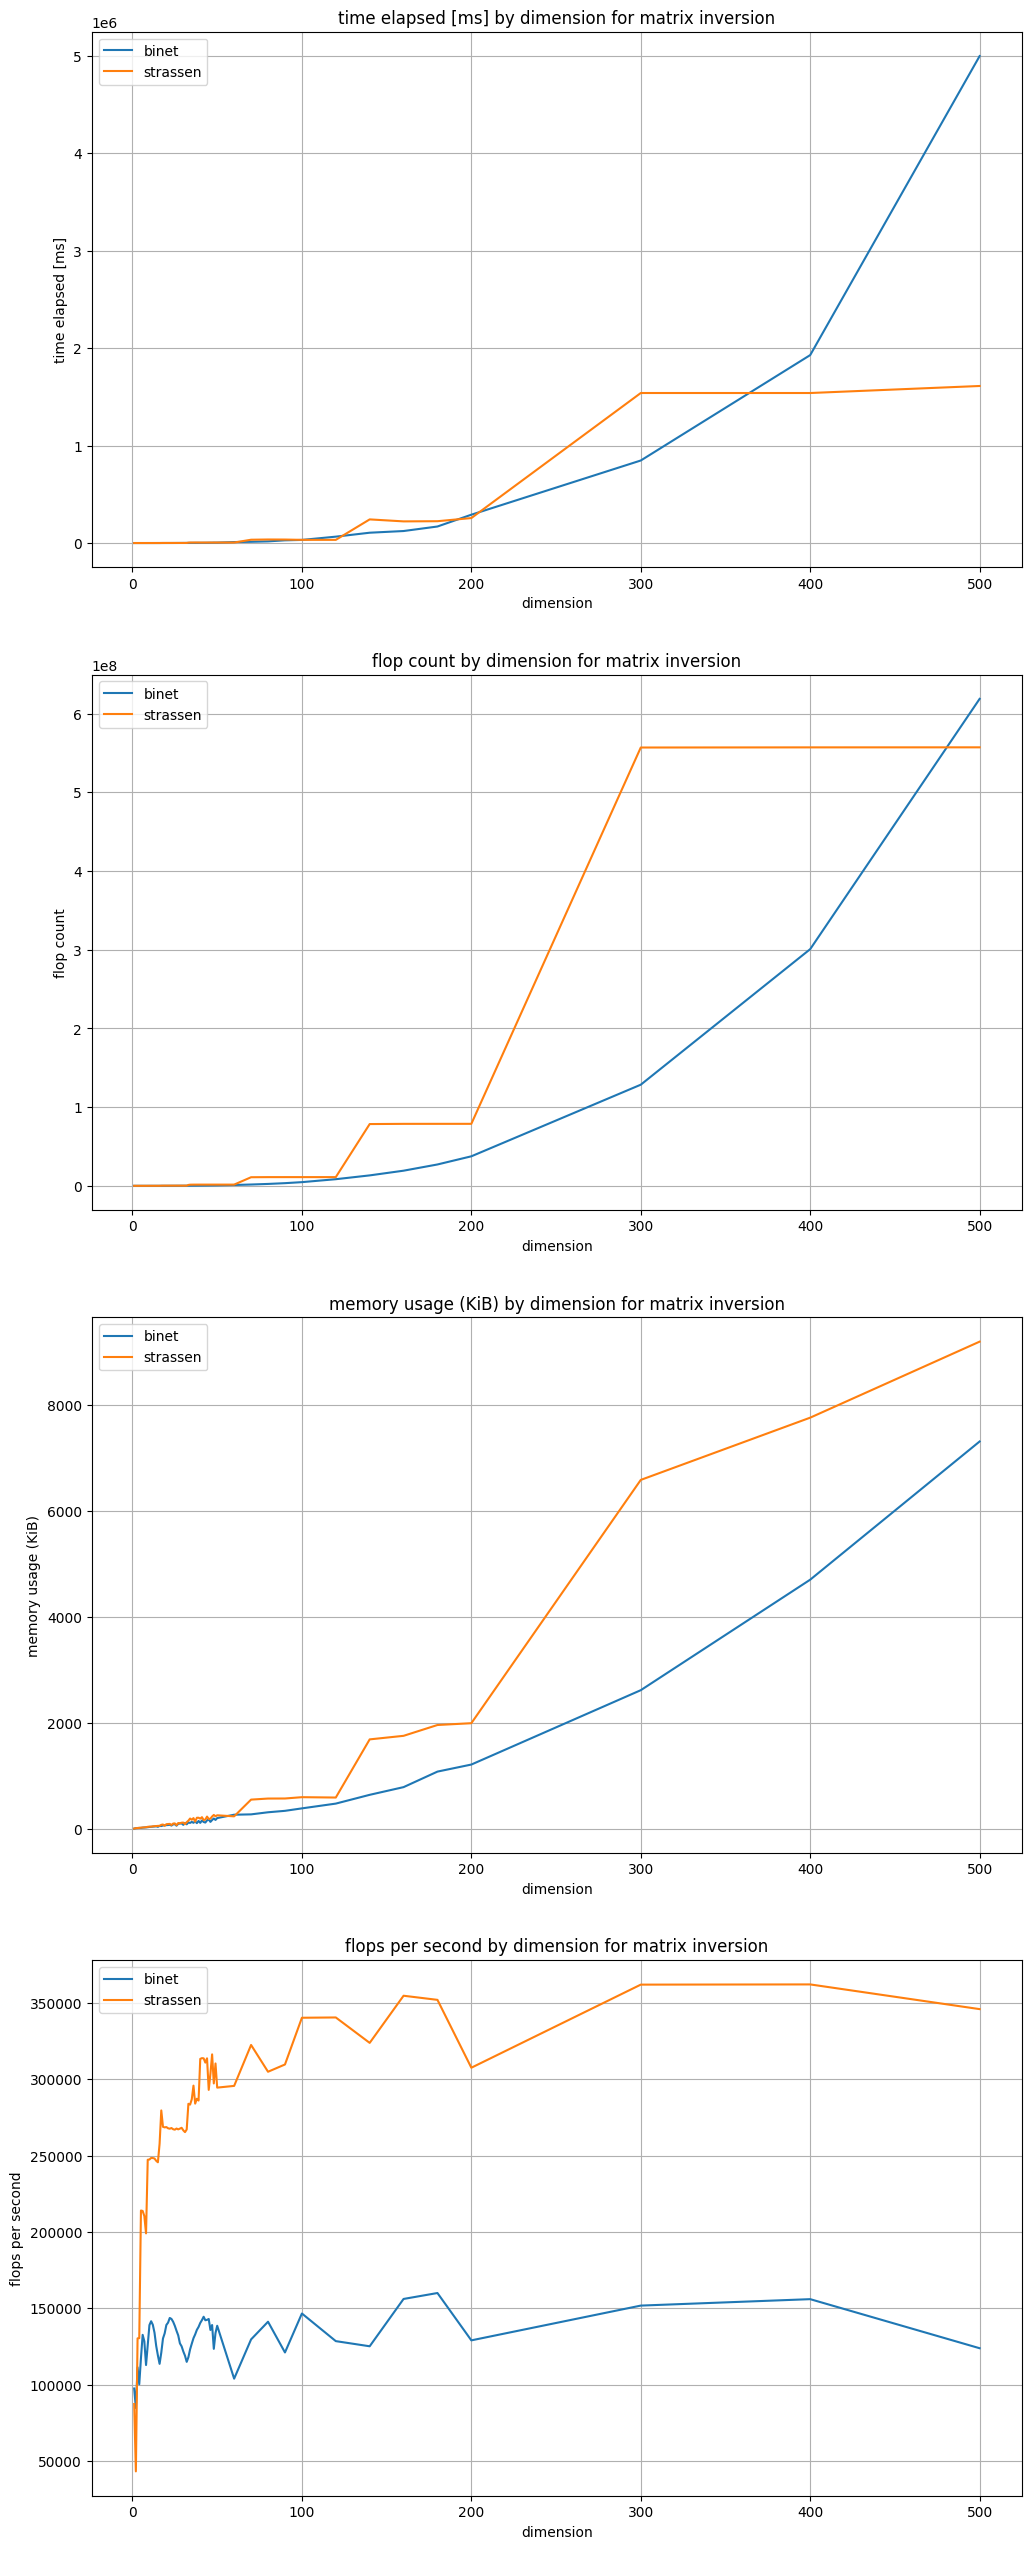

In [7]:
# functions testing performance of inverse
def inverse_performance(dim, mul_fun, file_path):
    A = generate_matrix(dim)
    tracemalloc.start()
    t0 = time()
    _, flop_count = inverse(A, mul_fun)
    t1 = time()
    _, mem_used = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    result = Result((t1-t0)*1000, flop_count, mem_used / 1024)
    append_result_to_file(file_path, dim, result)

inv_binet_file = "inv_binet.csv"
def inverse_performance_binet(dim):
    inverse_performance(dim, binet, inv_binet_file)

inv_strassen_file = "inv_strassen.csv"
def inverse_performance_strassen(dim):
    inverse_performance(dim, strassen, inv_strassen_file)

print("Testing inverse - binet...")
results_inverse_binet = test_performance(inv_binet_file, PERFORMANCE_TEST_DIMS, inverse_performance_binet)

print("Testing inverse - strassen...")
results_inverse_strassen = test_performance(inv_strassen_file, PERFORMANCE_TEST_DIMS, inverse_performance_strassen)

plot_results("matrix inversion", results_inverse_binet, results_inverse_strassen)

### LU decomposition and determinant

In [8]:
# decompose A to LU and calculate determinant
def LU(A, mul_fun):
    flop_count = 0
    
    def f(A):
        nonlocal flop_count
        # initialize result matrices as zeros
        L = np.zeros(A.shape)
        U = np.zeros(A.shape)
        # if matrix can be split further, split it
        if A.shape[0] > 1:
            # split matrix
            A11, A12, A21, A22 = split_matrix(A)
            # calculate L11 and U11
            L11, U11 = f(A11)
            # calculate inv(U11)
            U11_inv, f1 = inverse(U11, mul_fun)
            flop_count += f1
            # calculate L21
            L21, f1 = mul_fun(A21, U11_inv)
            flop_count += f1
            # calculate inv(L11)
            L11_inv, f1 = inverse(L11, mul_fun)
            flop_count += f1
            # calculate U12
            U12, f1 = mul_fun(L11_inv, A12)
            flop_count += f1
            # calculate S
            M1, f1 = mul_fun(A21, U11_inv)
            M2, f2 = mul_fun(M1, L11_inv)
            M3, f3 = mul_fun(M2, A12)
            S = A22 - M3
            flop_count += f1 + f2 + f3 + el_count(S)
            # calculate L22 and U22
            L22, U22 = f(S)
            # write the results into new matrices
            half_r, half_c = A11.shape
            L[:half_r, :half_c] = L11
            L[half_r:, :half_c] = L21
            L[half_r:, half_c:] = L22
            U[:half_r, :half_c] = U11
            U[:half_r, half_c:] = U12
            U[half_r:, half_c:] = U22
        # if you can no longer split matrix - trivial
        else:
            L[0,0] = 1
            U[0,0] = A[0,0]
        # return resulting matrix
        return L, U

    L, U = f(A)
    det = 1
    for i in range(A.shape[0]):
        det *= L[i,i] * U[i,i]
    return L, U, det, flop_count

Test correctness of the function

In [9]:
# function testing correctness of LU
#  may not pass some tests due to numerical instability
def LU_correctness(dim):
    A = generate_matrix(dim)
    L, U, det, _ = LU(A, binet)
    return np.all(np.abs(L@U - A) < EPS) and np.abs(det - np.linalg.det(A)) < EPS

test_correctness(LU_correctness)

Passed 50/50


True

Test performance of the function

Testing LU - binet...
Start: 13:21:40
End: 13:21:40
Finished testing in 0.027359485626220703s

Testing LU - strassen...
Start: 13:21:40
End: 13:21:40
Finished testing in 0.021515846252441406s



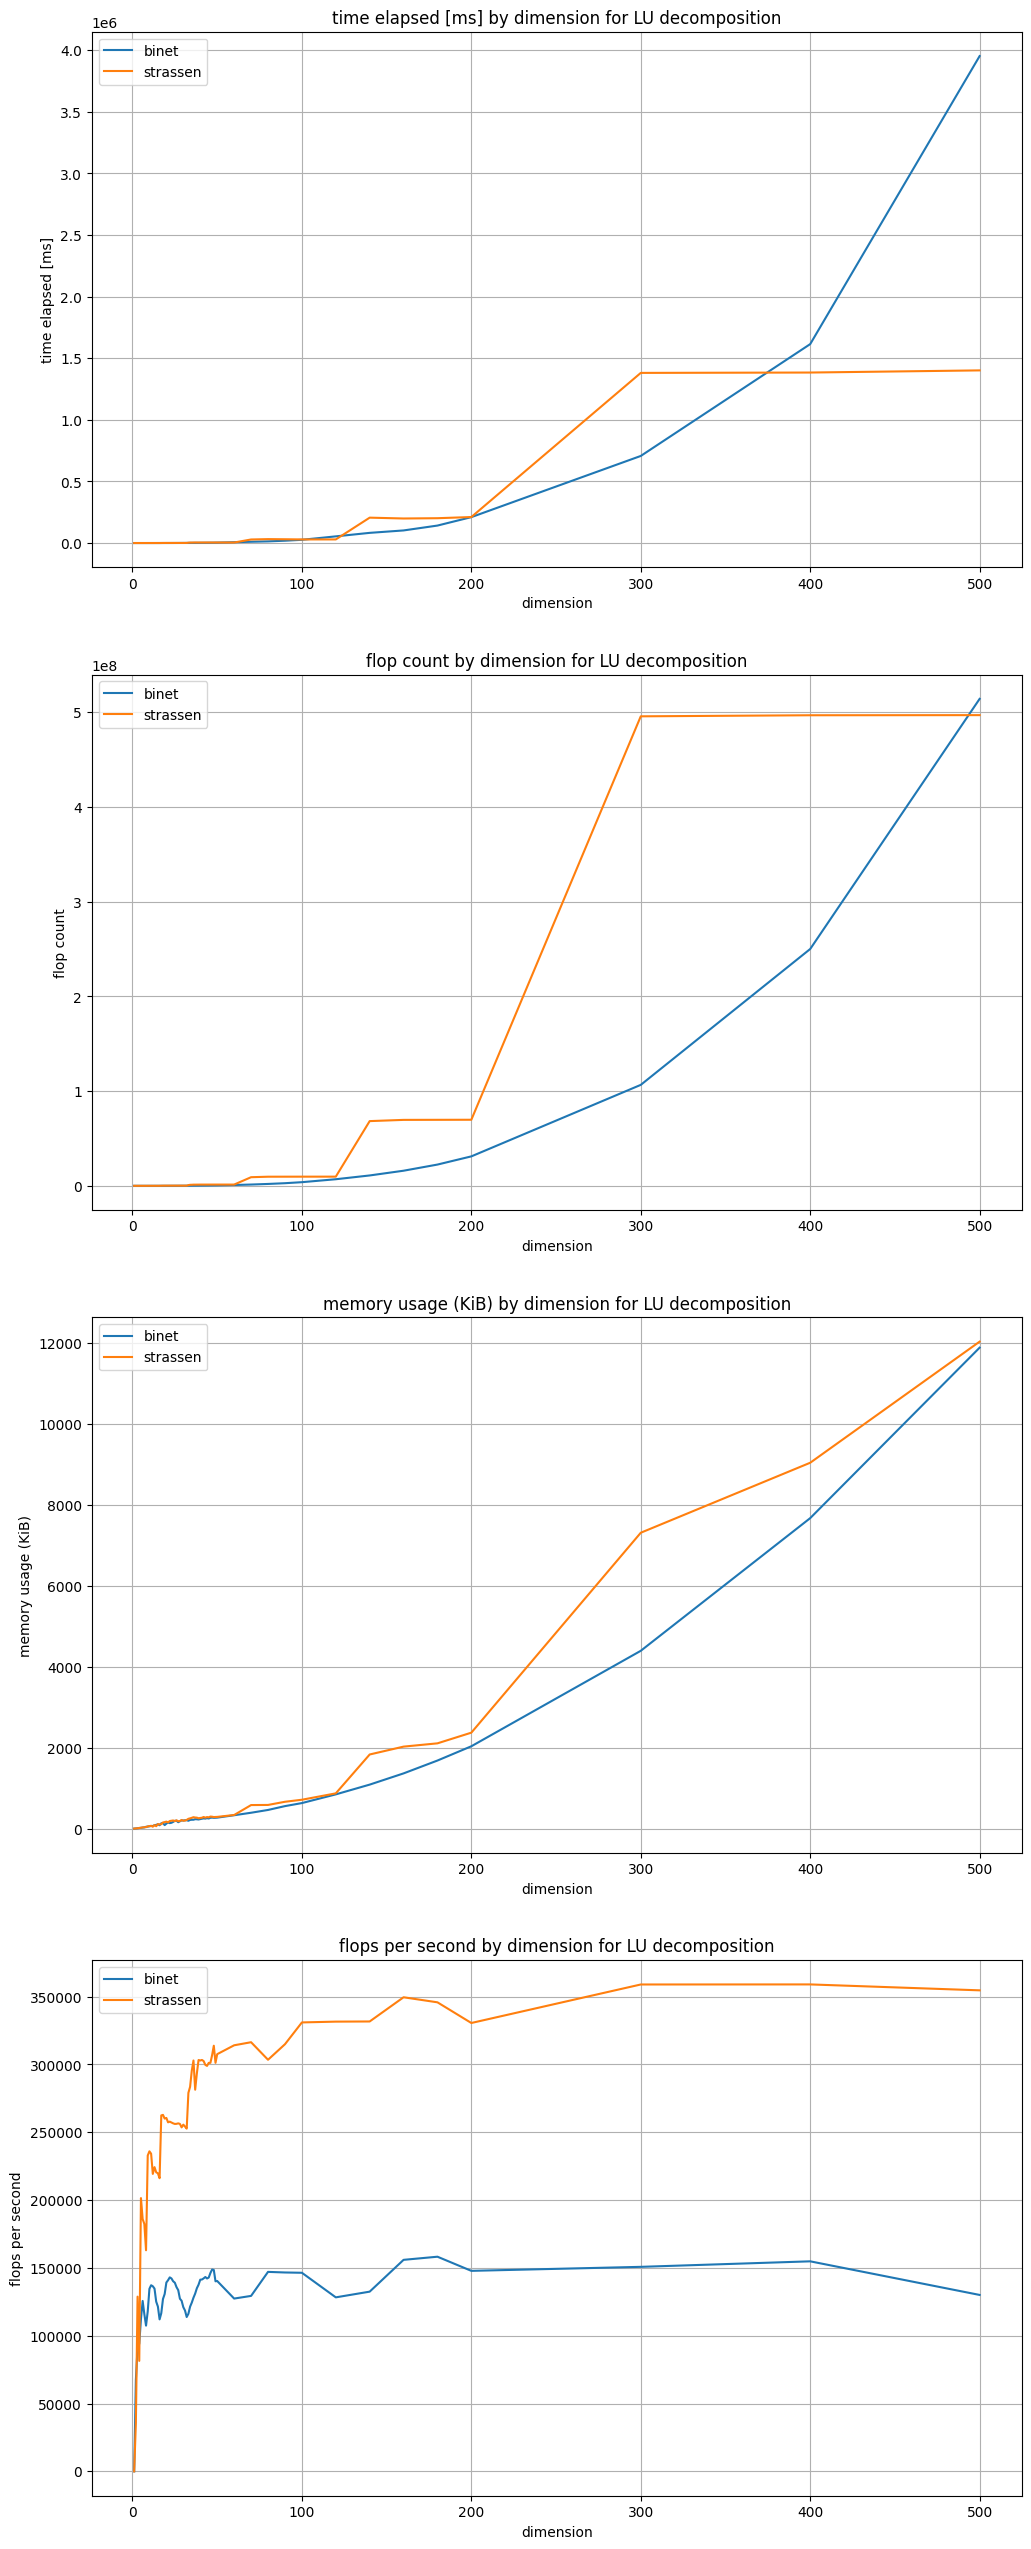

In [10]:
# functions testing performance of LU
def LU_performance(dim, mul_fun, file_path):
    A = generate_matrix(dim)
    tracemalloc.start()
    t0 = time()
    _, _, _, flop_count = LU(A, mul_fun)
    t1 = time()
    _, mem_used = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    result = Result((t1-t0)*1000, flop_count, mem_used / 1024)
    append_result_to_file(file_path, dim, result)

LU_binet_file = "LU_binet.csv"
def LU_performance_binet(dim):
    LU_performance(dim, binet, LU_binet_file)

LU_strassen_file = "LU_strassen.csv"
def LU_performance_strassen(dim):
    LU_performance(dim, strassen, LU_strassen_file)

print("Testing LU - binet...")
results_LU_binet = test_performance(LU_binet_file, PERFORMANCE_TEST_DIMS, LU_performance_binet)

print("Testing LU - strassen...")
results_LU_strassen = test_performance(LU_strassen_file, PERFORMANCE_TEST_DIMS, LU_performance_strassen)

plot_results("LU decomposition", results_LU_binet, results_LU_strassen)

### Gaussian elimination

In [11]:
# solve linear equation Ax=b using gaussian elimination
def gauss(A, b, mul_fun):
    flop_count = 0
    
    def f(A, b):
        nonlocal flop_count
        # initialize result vector as zeros
        x = np.zeros(b.shape)
        # if matrix and vector can be split further, split them
        if A.shape[0] > 1:
            # split matrix and vector
            half_n = A.shape[0]//2
            A11, A12, A21, A22 = split_matrix(A)
            b1, b2 = b[:half_n], b[half_n:]
            # calculate L11 and U11
            L11, U11, _, f1 = LU(A11, mul_fun)
            flop_count += f1
            # calculate inv(L11) and inv(U11)
            L11_inv, f1 = inverse(L11, mul_fun)
            U11_inv, f2 = inverse(U11, mul_fun)
            flop_count += f1 + f2
            # calculate S
            M1, f1 = mul_fun(A21, U11_inv)
            M2, f2 = mul_fun(M1, L11_inv)
            M3, f3 = mul_fun(M2, A12)
            S = A22 - M3
            flop_count += f1 + f2 + f3 + el_count(S)
            # calculate LS and US
            LS, US, _, f1 = LU(S, mul_fun)
            flop_count += f1
            # calculate C
            C11 = U11
            C12, f1 = mul_fun(L11_inv, A12)
            C22 = US
            flop_count += f1
            # calculate RHS1
            RHS1, f1 = mul_fun(L11_inv, b1)
            flop_count += f1
            # calculate RHS2
            LS_inv, f1 = inverse(LS, mul_fun)
            M1, f2 = mul_fun(LS_inv, b2)
            M2, f3 = mul_fun(LS_inv, A21)
            M3, f4 = mul_fun(M2, U11_inv)
            M4, f5 = mul_fun(M3, L11_inv)
            M5, f6 = mul_fun(M4, b1)
            RHS2 = M1 - M5
            flop_count += f1 + f2 + f3 + f4 + f5 + f6 + el_count(RHS2)
            # calculate xs
            x2 = f(C22, RHS2)
            M1, f1 = mul_fun(C12, x2)
            x1 = f(C11, RHS1 - M1)
            flop_count += f1 + el_count(M1)
            # assign to x
            x[:half_n] = x1
            x[half_n:] = x2
        # if you can no longer split matrix - trivial
        else:
            x[0] = b[0] / A[0,0]
        # return resulting matrix
        return x
    
    return f(A, b), flop_count

Test correctness of the function

In [12]:
# function testing correctness of gauss
#  may not pass some tests due to numerical instability
def gauss_correctness(dim):
    A = generate_matrix(dim)
    b = generate_vector(dim)
    result, _ = gauss(A, b, binet)
    return np.all(np.abs(result - np.linalg.solve(A, b)) < EPS)

test_correctness(gauss_correctness)

Passed 50/50


True

Test performance of the function

Testing gauss - binet...
Start: 13:21:46
End: 13:21:46
Finished testing in 0.027916669845581055s

Testing gauss - strassen...
Start: 13:21:46
End: 13:21:46
Finished testing in 0.02247309684753418s



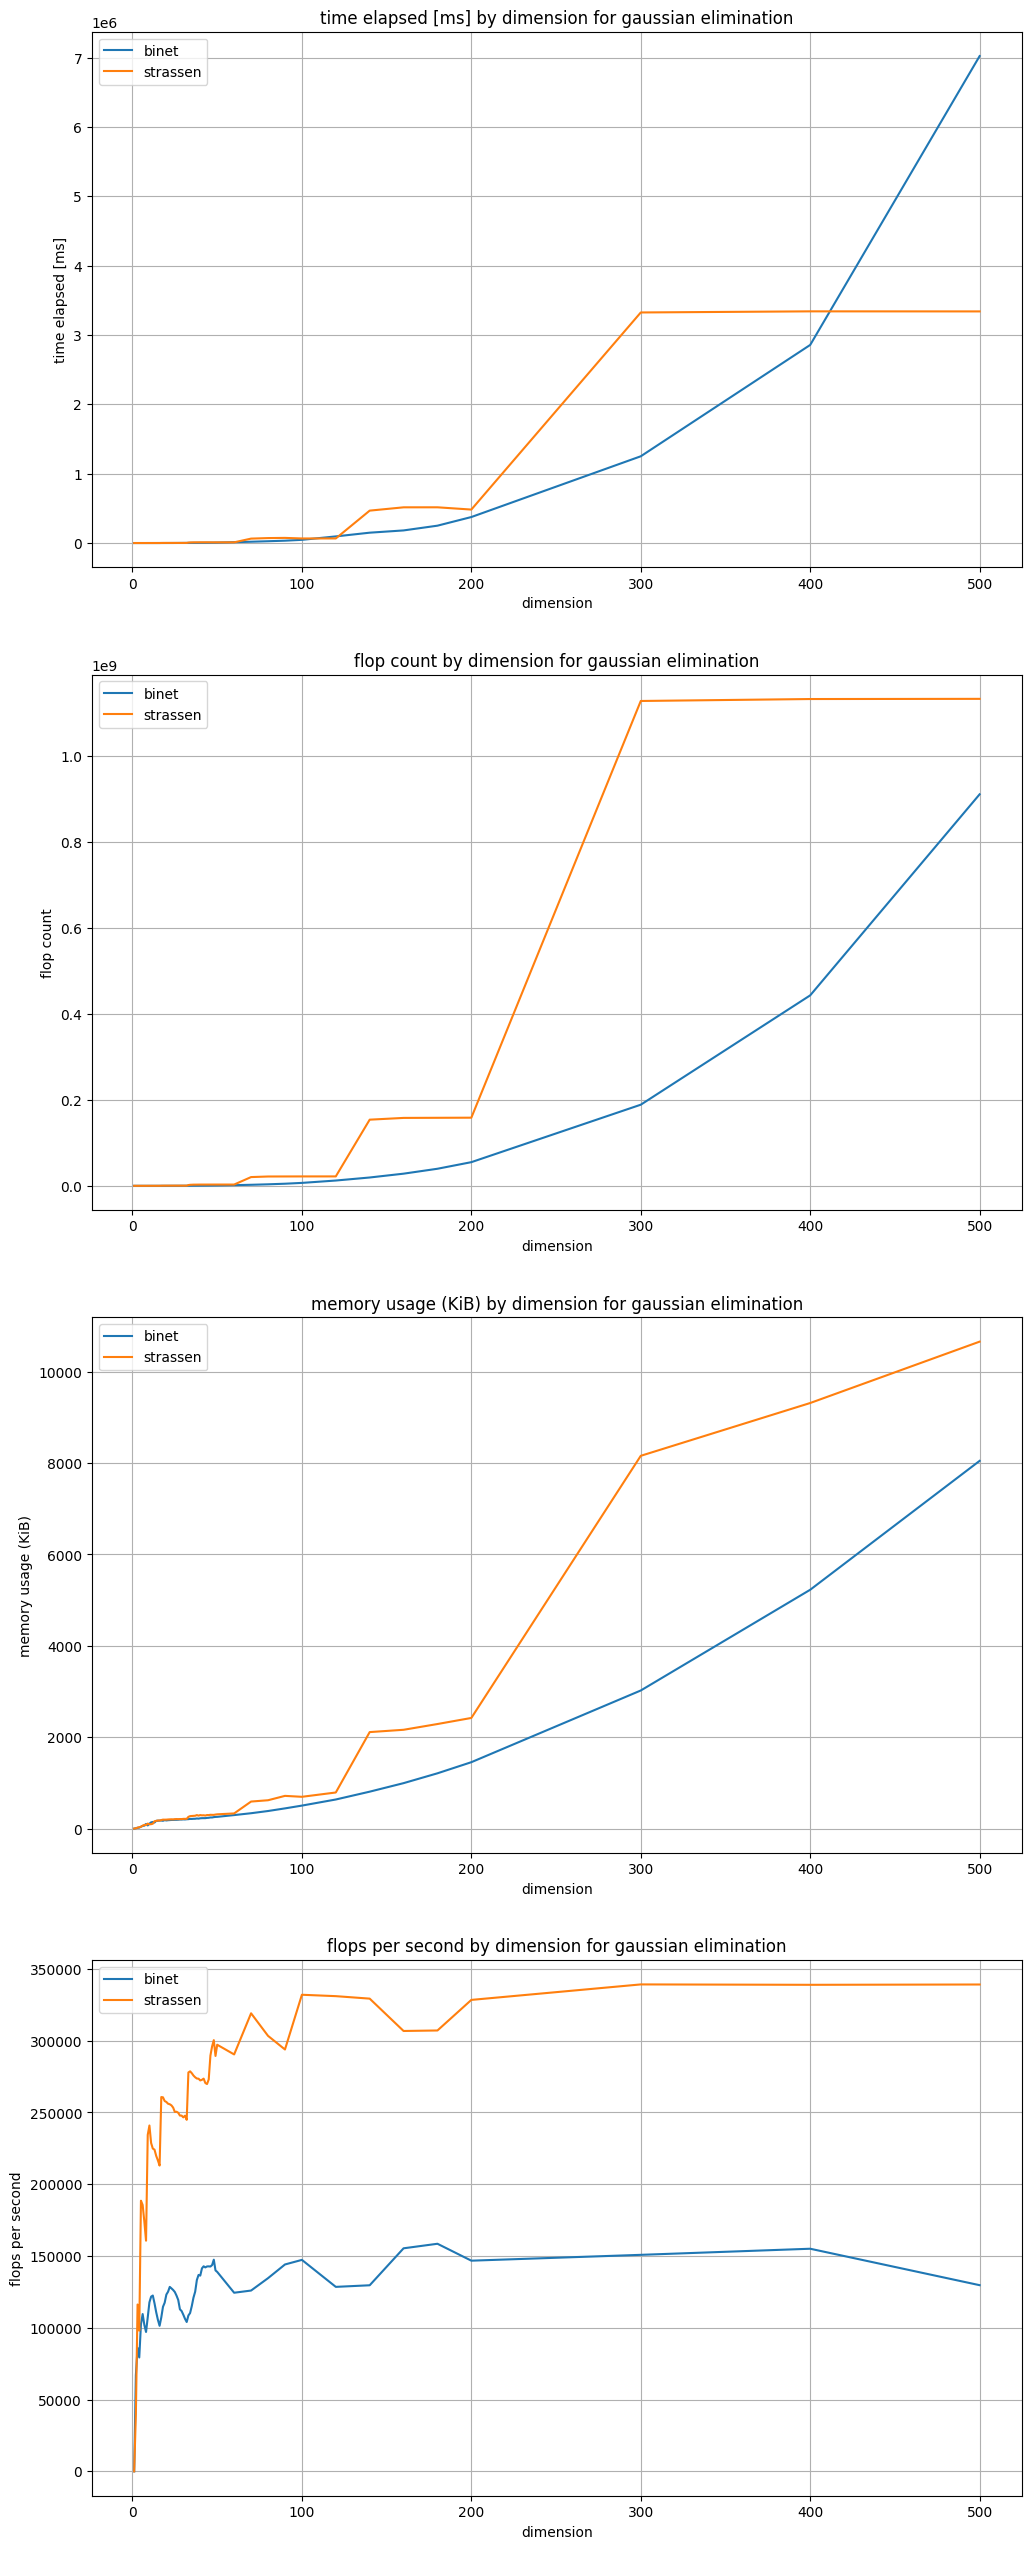

In [13]:
# functions testing performance of gauss
def gauss_performance(dim, mul_fun, file_path):
    A = generate_matrix(dim)
    b = generate_vector(dim)
    tracemalloc.start()
    t0 = time()
    _, flop_count = gauss(A, b, mul_fun)
    t1 = time()
    _, mem_used = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    result = Result((t1-t0)*1000, flop_count, mem_used / 1024)
    append_result_to_file(file_path, dim, result)

gauss_binet_file = "gauss_binet.csv"
def gauss_performance_binet(dim):
    gauss_performance(dim, binet, gauss_binet_file)

gauss_strassen_file = "gauss_strassen.csv"
def gauss_performance_strassen(dim):
    gauss_performance(dim, strassen, gauss_strassen_file)

print("Testing gauss - binet...")
results_gauss_binet = test_performance(gauss_binet_file, PERFORMANCE_TEST_DIMS, gauss_performance_binet)

print("Testing gauss - strassen...")
results_gauss_strassen = test_performance(gauss_strassen_file, PERFORMANCE_TEST_DIMS, gauss_performance_strassen)

plot_results("gaussian elimination", results_gauss_binet, results_gauss_strassen)